# Sklonowanie i wejście do repozytorium



In [2]:
!git clone https://github.com/shizzeer/credo-classifier.git

Cloning into 'credo-classifier'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 1), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 5.09 MiB | 20.03 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [11]:
%cd credo-classifier

/content/credo-classifier


# Rozpakowanie danych treningowych

In [15]:
!unzip images.zip

Archive:  images.zip
   creating: images/
   creating: images/artefacts/
 extracting: images/artefacts/10219929.png  
 extracting: images/artefacts/10219931.png  
 extracting: images/artefacts/10223942.png  
 extracting: images/artefacts/10228003.png  
 extracting: images/artefacts/10231268.png  
 extracting: images/artefacts/10231560.png  
 extracting: images/artefacts/10232861.png  
 extracting: images/artefacts/10233802.png  
 extracting: images/artefacts/10235049.png  
 extracting: images/artefacts/10235948.png  
 extracting: images/artefacts/10245995.png  
 extracting: images/artefacts/10259097.png  
 extracting: images/artefacts/1423633.png  
  inflating: images/artefacts/1423831.png  
 extracting: images/artefacts/1423932.png  
 extracting: images/artefacts/1424898.png  
 extracting: images/artefacts/1425966.png  
 extracting: images/artefacts/1426183.png  
 extracting: images/artefacts/1428338.png  
 extracting: images/artefacts/1428689.png  
 extracting: images/artefacts/14289

# Zaimportowanie bibliotek

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils import *

# Module autoreloading
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Załadowanie zestawu danych treningowych

In [41]:
(train_ds, validation_ds) = load_dataset('./images/')

Found 2354 files belonging to 4 classes.
Using 1884 files for training.
Found 2354 files belonging to 4 classes.
Using 470 files for validation.


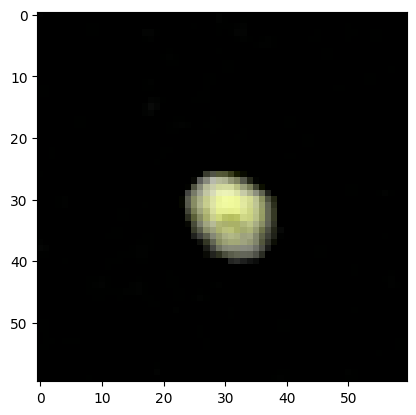

In [62]:
img_batch = train_ds.take(1)
batch_iterator = iter(img_batch)
image, label = next(batch_iterator)

plt.imshow(image[0].numpy().astype("uint8"))

# Push to repo

In [113]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	utils.py

nothing added to commit but untracked files present (use "git add" to track)
